In [242]:
from load_modules import *
from scipy.ndimage import gaussian_filter
import my_config
import time
# conda create --name tf_gpu tensorflow-gpu
# conda activate tf_gpu
# pip install pandas scikit-learn matplotlib colorspacious ipykernel
# pip install opencv-python pandas scikit-learn matplotlib colorspacious 
# os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

In [78]:
if my_config.USE_GPU:
    physical_devices = tf.config.list_physical_devices('GPU')
    #set memory amount to half of GPU
    if len(physical_devices) > 0:
        for device in physical_devices:
            print("Device:", device)
    else:
        print("No GPU devices found.")
    # Set GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                
        except RuntimeError as e:
            print(e)
        # Set environment variable for GPU memory allocation

    # Test for GPU device name
    name = tf.test.gpu_device_name()
    if name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(name))
    # Print the number of available GPUs
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU")

No GPU


In [ ]:
image_paths = os.listdir(r"models_4k")
base_path = r"models_4k"

all_model_paths = []
print(my_config.IMAGE_FOLDER)
print(my_config.ENCODER_PATH)
print(my_config.DECODER_PATH)

encoder = load_model(r"TrainedModels/316/encoder.h5")
decoder = load_model(r"TrainedModels/316/decoder.h5")
print("Encoder summary:" + str(encoder.summary()))
print("Decoder summary:" + str(decoder.summary()))
def encode(img):
    #make sure image is in correct format 2048x2048x3
    # img = Image.fromarray(img).resize((2048, 2048))
    img = np.asarray(img).reshape(-1,3).astype('float32')
    # pred_maps = encoder.predict(image)
    start = time.time()
    pred_maps = None
    # with tf.device('/device:GPU:0'):
    #     pred_maps = encoder.predict_on_batch(image)
    pred_maps = encoder.predict(img)
    #convert to numpy array
    # pred_maps = np.array(pred_maps)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    recovered = None
    # with tf.device('/device:GPU:0'):
    #     recovered = decoder.predict_on_batch(encoded)
    recovered = decoder.predict(encoded)

    end = time.time()
    # recovered = np.array(recovered).reshape((2048, 2048, 3))
    elapsed = end - start
    # recovered = np.clip(recovered, 0, 1)
    return recovered, elapsed
def calculate_deltaE(original, recovered):  # assuming this function is defined
    WIDTH = original.shape[0]
    HEIGHT = original.shape[1]
    # Convert the images to the CAM02-UCS color space and calculate the delta E loss
    if original.shape[0] != recovered.shape[0] or original.shape[1] != recovered.shape[1]:
        print("original shape:", original.shape)
        print("recovered shape:", recovered.shape)
        print("original and recovered shape do not match")
        original = original.reshape((WIDTH, HEIGHT, 3))
        recovered = recovered.reshape((WIDTH, HEIGHT, 3))
    original_lab = colorspacious.cspace_convert(np.array(original), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    recovered_lab = colorspacious.cspace_convert(np.array(recovered), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    delta_e = np.sqrt(np.sum((original_lab - recovered_lab)**2, axis=2))
    # Plot the delta E loss in the third subplot
    return delta_e

def age_mel(v, t, r=0.08):
    """
    v is original volume fraction of melanin
    t is number of decades
    r is rate of decline (typical is 8%)
    """
    v_prime = v-(t*r)*v
    return v_prime

def age_hem(v, t, r_Hbi=0.06, r_Hbe=0.1, zeta=0.5):
    """
    v is original volume fraction of hemoglobin
    t is number of decades
    r is rate of decline (typical is 6%)
    """
    v_prime = v-t*(r_Hbi+zeta*r_Hbe)*v
    return v_prime

models_4k
/TrainedModels/316/encoder.h5
/TrainedModels/316/decoder.h5
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 3)]               0         
                                                                 
 encoder_dense_0 (Dense)     (None, 75)                300       
                                                                 
 encoder_dense_2 (Dense)     (None, 75)                5700      
                                                                 
 encoder_output (Dense)      (None, 5)                 380       
                                                                 
Total params: 6,380
Trainable params: 6,380
Non-trainable params: 0
_________________________________________________________________
Encoder summary:None
Model: "decoder"
_________________________________________________________________
 Layer (type)  

In [176]:
image_paths = os.listdir(r"models_4k")
images = []
names = []
for image_path in image_paths:
    folder_name = image_path.split('.')[0]
    names.append(folder_name)
    image_path = os.path.join(my_config.IMAGE_FOLDER, image_path)
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    if np.max(image) > 1:
        image = image/255.0
    images.append(image)
print(names)
all_model_paths = []
encoder = load_model(r"TrainedModels/316/encoder.h5")
decoder = load_model(r"TrainedModels/316/decoder.h5")
def encode(img):
    image = np.asarray(img).reshape(-1,3)
    # pred_maps = encoder.predict(image)
    start = time.time()
    pred_maps = None
    with tf.device('/device:GPU:0'):
        pred_maps = encoder.predict_on_batch(image)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    recovered = None
    with tf.device('/device:GPU:0'):
        recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    # recovered = np.clip(recovered, 0, 1)
    return recovered, elapsed
def calculate_deltaE(original, recovered):  # assuming this function is defined
    WIDTH = original.shape[0]
    HEIGHT = original.shape[1]
    # Convert the images to the CAM02-UCS color space and calculate the delta E loss
    if original.shape[0] != recovered.shape[0] or original.shape[1] != recovered.shape[1]:
        print("original shape:", original.shape)
        print("recovered shape:", recovered.shape)
        print("original and recovered shape do not match")
        original = original.reshape((WIDTH, HEIGHT, 3))
        recovered = recovered.reshape((WIDTH, HEIGHT, 3))
    original_lab = colorspacious.cspace_convert(np.array(original), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    recovered_lab = colorspacious.cspace_convert(np.array(recovered), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    delta_e = np.sqrt(np.sum((original_lab - recovered_lab)**2, axis=2))
    # Plot the delta E loss in the third subplot
    return delta_e

['m46_4k', 'metina', 'm64_4k', 'm98_4k', 'm141_4k', 'm53_4k', 'm32']


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


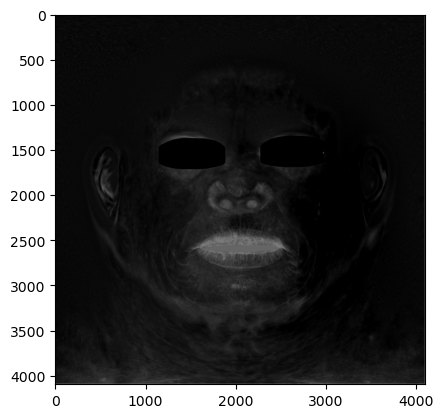

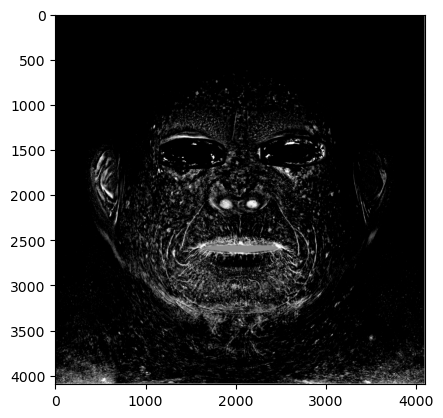

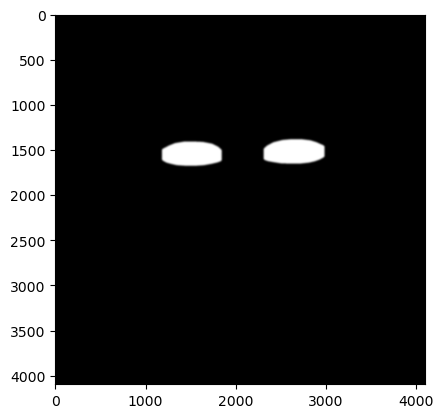

min 0.0 mean 0.05436656106282451 max 1.0
min 0.0 mean 0.05932998074092356 max 0.9810353912004658


In [295]:
hem_mask_path = r"sunspots/hem_mask.png"
mel_mask_path = r"sunspots/mel_mask.png"
eye_mask_path = r"sunspots/eye_mask.png"
# eye_lip_mask_path = r"sunspots/eye_lip_mask.png"


hem_mask = cv2.imread(hem_mask_path, cv2.IMREAD_GRAYSCALE) 
mel_mask = cv2.imread(mel_mask_path, cv2.IMREAD_GRAYSCALE)
eye_mask = cv2.imread(eye_mask_path, cv2.IMREAD_GRAYSCALE)
#expand masked area of eye mask
eye_mask = cv2.dilate(eye_mask, np.ones((45, 55), np.uint8), iterations=1)
#shrink masked area of eye mask
# eye_mask = cv2.erode(eye_mask, np.ones((5,5), np.uint8), iterations=4)

#reshape to 4096x4096
hem_mask = cv2.resize(hem_mask, (4096, 4096))/255.0
mel_mask = cv2.resize(mel_mask, (4096, 4096))/255.0
eye_mask = cv2.resize(eye_mask, (4096, 4096))/255.0


hem_mask = np.array(hem_mask)
mel_mask = np.array(mel_mask)
eye_mask = np.array(eye_mask)
eye_mask = gaussian_filter(eye_mask, sigma=5)
# eye_mask = gaussian_filter(eye_mask, sigma=20)
#add gaussian blur to eye mask
# eye_mask = cv2.GaussianBlur(eye_mask, ksize=5, sigmaX=50, sigmaY=50)
hem_mask = 1 - hem_mask 
mel_mask = 1 - mel_mask
hem_mask = cv2.bitwise_xor(hem_mask, eye_mask)
mel_mask = cv2.bitwise_xor(mel_mask, eye_mask)

#clamp 0 to 1

#threshold

plt.imshow(hem_mask, cmap='gray')
plt.show()
plt.imshow(mel_mask, cmap='gray')
plt.show()
plt.imshow(eye_mask, cmap="gray")
plt.show()
print(f"min {np.min(mel_mask)} mean {np.mean(mel_mask)} max {np.max(mel_mask)}")

print(f"min {np.min(hem_mask)} mean {np.mean(hem_mask)} max {np.max(hem_mask)}")

shape of hem_mask: (4096, 4096)
min 0.03346329554915428 mean 0.16528354585170746 max 0.6082751154899597
min 0.025432106107473373 mean 0.13648873567581177 max 0.6622890830039978
shape of recovered: (16777216, 3)


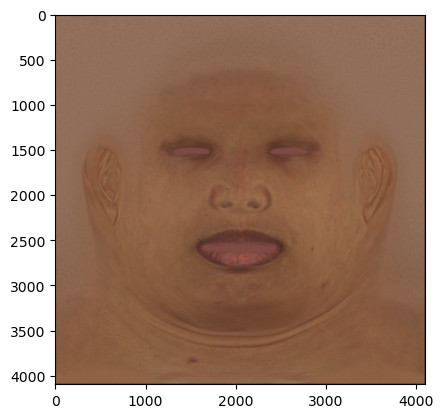

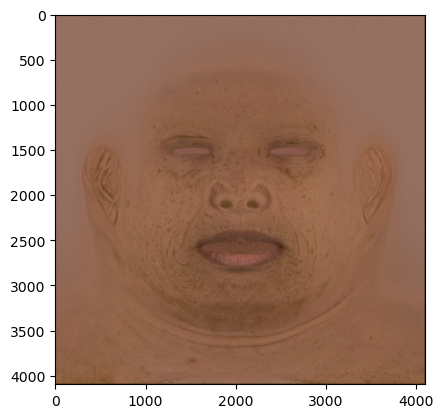

size of image: (4096, 4096, 3)
max pixel value: 0.6850719451904297
min pixel value: 0.0537479929625988
min -0.10027988255023956 mean -0.0060667796060442924 max 0.606253981590271
min -0.07621271163225174 mean 0.00626255851238966 max 0.6607530117034912
shape of recovered: (16777216, 3)


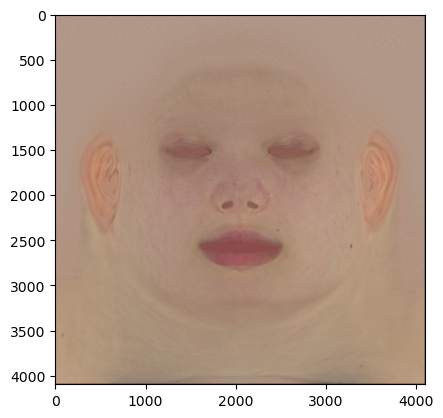

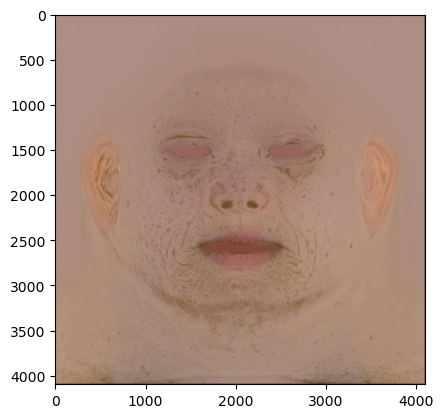

size of image: (4096, 4096, 3)
max pixel value: 0.8200470805168152
min pixel value: 0.05774606764316559
min -0.018970005214214325 mean 0.3336601257324219 max 0.6058624982833862
min 0.0012690704315900803 mean 0.2644549012184143 max 0.6604555249214172
shape of recovered: (16777216, 3)


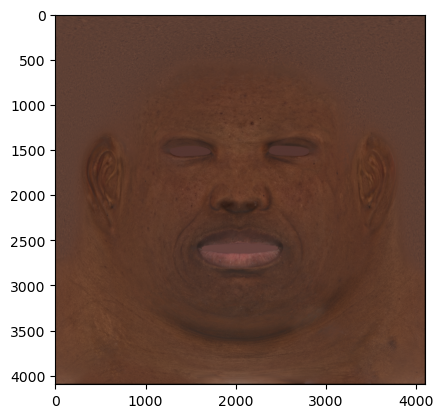

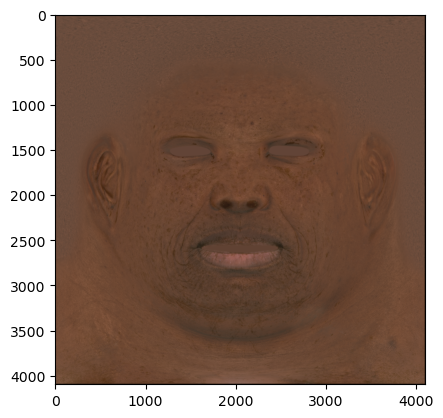

size of image: (4096, 4096, 3)
max pixel value: 0.6517888903617859
min pixel value: 0.054012879729270935
min 0.01697242446243763 mean 0.49287623167037964 max 0.6065470576286316
min 0.012899043038487434 mean 0.38545939326286316 max 0.6609757542610168
shape of recovered: (16777216, 3)


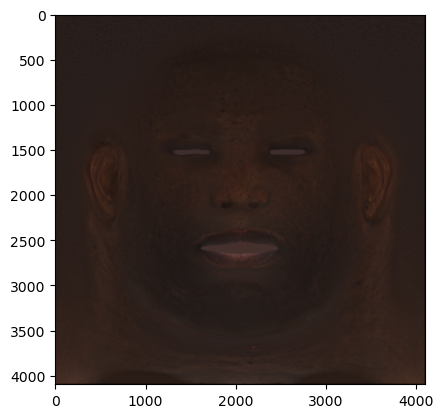

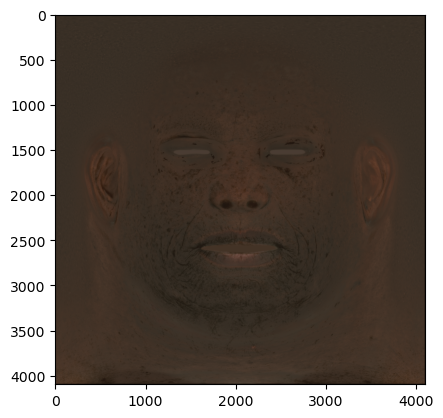

size of image: (4096, 4096, 3)
max pixel value: 0.5550377368927002
min pixel value: 0.053377799689769745
min -0.12033900618553162 mean -0.03945447504520416 max 0.6048188209533691
min -0.09145764261484146 mean -0.019112050533294678 max 0.6596623063087463
shape of recovered: (16777216, 3)


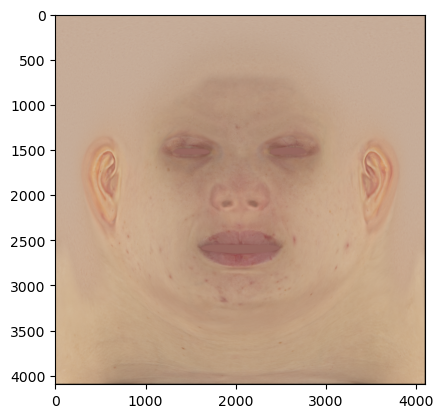

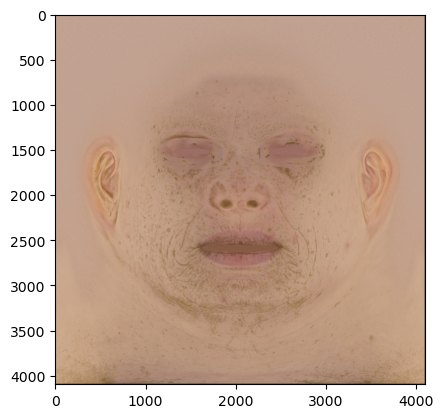

size of image: (4096, 4096, 3)
max pixel value: 0.8465471863746643
min pixel value: 0.058564648032188416
min -0.06582620739936829 mean 0.03668559715151787 max 0.6065470576286316
min -0.05002791807055473 mean 0.03875431418418884 max 0.6609757542610168
shape of recovered: (16777216, 3)


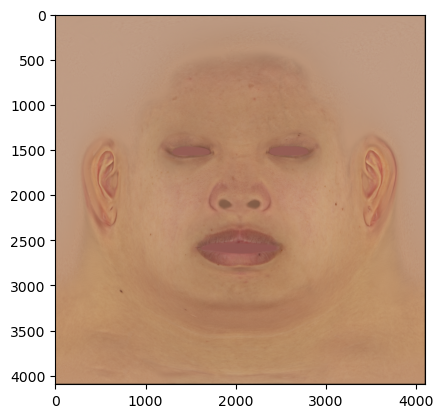

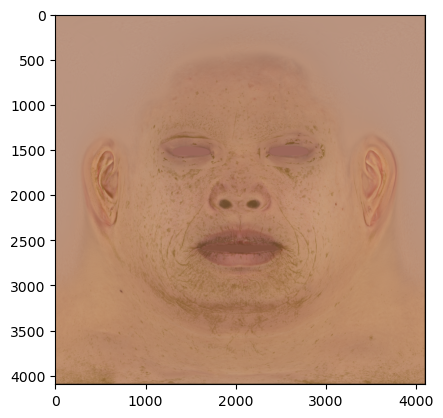

size of image: (4096, 4096, 3)
max pixel value: 0.8790023922920227
min pixel value: 0.059158943593502045
min -0.11354318261146545 mean -0.005631896201521158 max 0.6065470576286316


ValueError: operands could not be broadcast together with shapes (4194304,) (16777216,) 

In [296]:
# fig,ax = plt.subplots(5,5, figsize=(16,14))
subjects_meta = ['m141_4k', 'm46_4k', 'm53_4k', 'm64_4k', 'm98_4k']
idx = 0
# hem_mask_path = r"m32_Ch.png"
# mel_mask_path = r"m32_Cm.png"
# hem_mask = cv2.imread(hem_mask_path, cv2.IMREAD_GRAYSCALE)/255.0 
# mel_mask = cv2.imread(mel_mask_path, cv2.IMREAD_GRAYSCALE)/255.0
# hem_mask = np.array(hem_mask)
# mel_mask = np.array(mel_mask)

print(f"shape of hem_mask: {hem_mask.shape}")
#reshape to 4096x4096
# hem_mask = np.resize(hem_mask, (4096,4096))
# mel_mask = np.resize(mel_mask, (4096,4096))
#convert to binary

for image, folder_name in zip(images, names):
    WIDTH = image.shape[0]
    HEIGHT = image.shape[1]
    image = np.asarray(image)
    image_numpy = image.reshape((WIDTH, HEIGHT, 3))
    pred_maps, encode_time = encode(image_numpy)

    print(f"min { np.min(pred_maps[:,0])} mean {np.mean(pred_maps[:,0])} max {np.max(pred_maps[:,0])}")
    pred_maps[:,0] = np.asarray(age_mel(pred_maps[:,0], 3)+0.2*mel_mask.reshape(-1,))
    print(f"min { np.min(pred_maps[:,0])} mean {np.mean(pred_maps[:,0])} max {np.max(pred_maps[:,0])}")

    pred_maps[:,1] = np.asarray(age_hem(pred_maps[:,1], 2)+0.025*hem_mask.reshape(-1,))
    # pred_maps[:,0] *= 1.4
    pred_maps[:,1] = np.asarray(pred_maps[:,1])

    # pred_maps[:,3] = np.asarray(0.9*age_hem(pred_maps[:,3], 2)-0.025*hem_mask.reshape(-1,))
    pred_maps[:,3] *= 0.98

    pred_maps[:,4] *= 0.95
   
    recovered, decode_time = decode(pred_maps)
    print(f"shape of recovered: {recovered.shape}")
    recovered = np.asarray(recovered).reshape((WIDTH, HEIGHT, 3))
    
    # recovered_lab= colorspacious.cspace_convert(recovered, 'sRGB1', 'CAM02-UCS')
    # recovered = np.asarray(decoded_increased_Cm).reshape((WIDTH, HEIGHT, 3))
    plt.imshow(image)
    plt.show()
    plt.imshow(recovered)
    plt.show()
    #save the image 
    #print size of image
    print(f"size of image: {recovered.shape}")
    #max min pixel values
    print(f"max pixel value: {np.max(recovered)}")
    print(f"min pixel value: {np.min(recovered)}")
    #clamp the values to 0-1
    recovered = np.clip(recovered, 0, 1)
    # experiment_name = input("Enter experiment name: ")
    # file_NAME = f"{experiment_name}_{subjects_meta[idx]}.png"
    # plt.imsave(file_NAME, recovered)
    idx += 1
    